<a href="https://colab.research.google.com/github/GruAna/VU/blob/master/m_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras-OCR

## Packages

These two versions of keras-ocr and matplotlib works together on Google Colab

In [ ]:
!pip install keras-ocr==0.8.9
!pip install matplotlib==3.3.0
!pip install imgaug==0.2.6      # because of incompatibility warning

     |████████████████████████████████| 41 kB 290 kB/s 
     |████████████████████████████████| 930 kB 9.6 MB/s 
     |████████████████████████████████| 603 kB 48.1 MB/s 
     |████████████████████████████████| 9.5 MB 51.9 MB/s 
     |████████████████████████████████| 50 kB 8.7 MB/s 
  Created wheel for validators: filename=validators-0.19.0-py3-none-any.whl size=19553 sha256=ce028a7c32b3a5c7807197692414b99840ad95bb8e17af16f3d8406fda15e94a
  Stored in directory: /root/.cache/pip/wheels/fe/5d/69/ff53a908b9f14fb7730a58fdede0fac4cdc99ef3624ec76d05
Successfully built validators
     |████████████████████████████████| 11.5 MB 5.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1

     |████████████████████████████████| 631 kB 5.3 MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-py3-none-any.whl size=654017 sha256=d09a720af935f34d51b0f86f5aeb887402819416bee7a96e807add010d86f3ee
  Stored in directory: /root/.cache/pip/wheels/89/72/98/3ebfdba1069a9a8eaaa7ae7265cfd67d63ef0197aaee2e5f9c
Successfully built imgaug
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


Mount google drive.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import cv2 as cv
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd

from tqdm import tqdm

import keras_ocr

In [ ]:
!cp drive/MyDrive/Colab_Notebooks/VU/utils.py .
from utils import *

## Setup

In [ ]:
# whether images are to be resized (skrinking)

resize = False
width = 300

## Dataset loading

**CTW1500 dataset**

Get images. Update location of images **manually**.

In [ ]:
# path to image directory, get full path to all files
imgs_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/FewImages/images/'
(_, _, filenames) = next(os.walk(imgs_dir))
filenames.sort()
list_img_paths = [os.path.join(imgs_dir, file) for file in filenames]

In [ ]:
# load images
original_images = [(cv.imread(file)) for file in list_img_paths]
                        
# shrink images
if resize:
    images = shrink_all(original_images, width)
else:
    images = original_images.copy()

Get paths to files with labels. Update location **manually**.

In [ ]:
labels_dir = '/content/drive/MyDrive/Colab_Notebooks/VU/FewImages/labelsxml/'
(_, _, xml_files) = next(os.walk(labels_dir))
xml_files.sort()
list_xml_paths = [os.path.join(labels_dir, file) for file in xml_files]

Get ground truths from all xml files

In [ ]:
from google.colab.patches import cv2_imshow

ground_truth = []

# if images where resized we need to resize also the coordinates in gt
if resize:
    for i, file in enumerate(list_xml_paths):
        ratio = width / original_images[i].shape[1]
        if ratio > 1:
            ratio = 1
        ground_truth.append(get_labels_xml(file, scaling_ratio=ratio))
else:
    for i, file in enumerate(list_xml_paths):
        ground_truth.append(get_labels_xml(file))

# ground_truth is in the is a list of tuples, where first is the gt word 
# and second is an array of top left and bottom right coordinates

## Prediction

Run OCR method.

In [ ]:
# keras-ocr will automatically download pretrained weights for the detector and recognizer.
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


Adjust batch size based on your GPU.

In [ ]:
predictions = []

# adjust batch size (step)
# step = 1 # for large images (at least one has one dimension greater than 800px)
step = 3                                  # batch size
number_of_batches = len(images) // step   # how many times does a batch of given step size fits to list_img_paths (based on length) (integer division)
for i in tqdm(range(number_of_batches)):
    if (i+1)*step+1 < step*number_of_batches:
        predictions += (pipeline.recognize(images[i*step : (i+1)*step]))
    # else is for last, possibly incomplete, batch
    else:
        predictions += (pipeline.recognize(images[i*step : ]))
    # each list of predictions in prediction_groups is a list of (word, box) tuples.


 33%|███▎      | 2/6 [01:18<02:40, 40.00s/it]

100%|██████████| 6/6 [03:38<00:00, 36.36s/it]


In [ ]:
# # Plot the predictions
# fig, axs = plt.subplots(nrows=len(images), figsize=(200, 200))
# for ax, image, predicts in zip(axs, images, predictions):
#     keras_ocr.tools.drawAnnotations(image=image, predictions=predicts, ax=ax)

## Results postprocessing

Calculate bounding rectangles for detected words in an image.

For all images.

Replace polygon coordinates by these two rectangle coordinates.

In [ ]:
predicted = []
for i in range(len(original_images)):
    results = []
    for text, box in predictions[i]:
        results.append((text, bounding_rectangle(box)))
    predicted.append(results)

Compare bounding boxes of predicition and ground truth.

Count Intersection over Union (IoU) metric for bounding boxes. Store for all images in a list `iou_images`.

Count Character Error Rate (CER) metric for characters in words. Store for all images in a list `cer_images`.

In [ ]:
iou_images = []
cer_images = []

# loop through images:
for i in range(len(images)):
    # separate list on columns (iterate through tuples in the list)
    predicted_cols = list(zip(*predicted[i]))
    ground_truth_cols = list(zip(*ground_truth[i]))
    # take only coordinate arrays from list for each images
    pred_boxes = predicted_cols[1]
    gt_boxes = ground_truth_cols[1]
    iou_from_image = iou_image(pred_boxes, gt_boxes)

    iou_text_regions = group_text(iou_from_image)

    # take only labels for each image
    pred_labels = predicted_cols[0]
    gt_labels = ground_truth_cols[0]

    # compare corresponding labels
    # comparision is a list of all text regions on one image
    comparision = []
    for gt_ind, observation in enumerate(iou_text_regions):
        pred_ind = observation[1]
        predicted_text = " ".join([pred_labels[i] for i in pred_ind])
        gt_pred_text = (gt_labels[gt_ind], predicted_text)
        
        # comparision for one text region (on one image)
        comparision.append((compare_text_cer(gt_pred_text)))

    iou_images.append((iou_text_regions))
    cer_images.append((comparision))

### Metrics
Metrics for each image (average of values of all regions in one image).

IoU (detection) `iou_in_image`

CER (recognition) `cer_in_image`

In [ ]:
iou_in_image = []
cer_in_image = []
for i in range(len(images)):
    mean_in_regions = [average(list(zip(*cer_images[i][j]))[2]) for j in range(len(cer_images[i]))]
    cer_in_image.append(average(mean_in_regions))
    iou_in_image.append(average(list(zip(*iou_images[i]))[0]))

## Overall results for dataset

In [ ]:
df_results = pd.DataFrame(list(zip(filenames, iou_in_image, cer_in_image)), columns =['Filename', 'IoU', 'CER'])
mean_iou = round(df_results['IoU'].mean(), 3) * 100
mean_cer = 100 - round(df_results['CER'].mean(), 3) * 100
print(f"mean IoU accuracy = {mean_iou}%, mean CER accuracy = {mean_cer}%")

df_results

mean IoU accuracy = 74.6%, mean CER accuracy = 75.9%


,Filename,IoU,CER
0,0001.jpg,0.873041,0.265007
1,0002.jpg,0.770933,0.021429
2,0003.jpg,0.826758,0.293336
3,0004.jpg,0.715432,0.202581
4,0005.jpg,0.828897,0.268571
5,0006.jpg,0.742141,0.273810
6,0007.jpg,0.846139,0.134815
7,0008.jpg,0.632900,0.272748
8,0009.jpg,0.690617,0.427272
9,0010.jpg,0.613194,0.402843


### Save results

In [ ]:
# set and create output directory if it doesn't exist

output_dir = 'results'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

Specify unique filename and specification.

Specification is an array of first used method, second some useful infromation.

In [ ]:
# SELECT FROM OR CREATE OWN, COMMENT UNUSED:

# basic keras-OCR (original image size, case insensitive, only alphanumeric)
file_name = "kerasOCR_basic"
specifications = ["keras-OCR", "original image width, case insensitive, only alphanumeric"]

# basic keras-OCR (300px image width, case insensitive, only alphanumeric)
# file_name = "kerasOcr_smallimgs"
# specifications = ["keras-OCR", "300px image width, case insensitive, only alphanumeric"]

In [ ]:
# create file with results (specify method and other parameters)

with open('%s/result_%s.txt' % (output_dir, file_name), 'w') as output_file:
    output_file.write(": ".join(str(text) for text in specifications))
    output_file.write("\n"+f"iou = {mean_iou}")
    output_file.write("\n"+f"cer = {mean_cer}")

Visualize bounding rectangles and corresponing words.

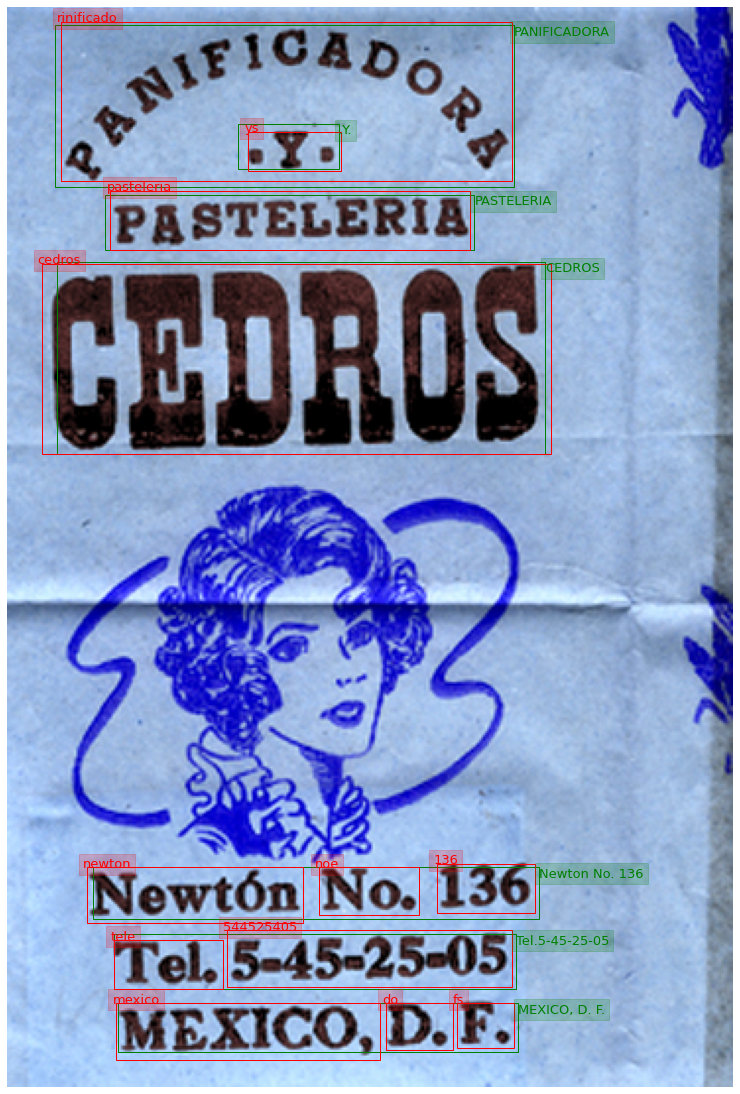

In [ ]:
# all images / one sample image
# for i in range(len(images)):
i = 0

im = plot_results(images[i], ground_truth[i], predicted[i])  
im.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

im.savefig('%s/result_%s.png' % (output_dir, file_name))
im.show()
